#  Visualizing Adoption and Return Trends in Sonoma Animal Data
03/15/2024

#### Rafael L.S. Reis, Dalia Cabrera Hurtado, Gabe Myers

## Introduction
This notebook aims to explore trends in animal adoption and return outcomes using the Sonoma Animal Shelter dataset. With over 30,000 records capturing detailed information on dogs, cats, and other animals—including breed, age, coat color, and length of stay—our goal is to uncover patterns that may inform shelter management practices and adoption strategies. In particular, we investigate how breed types (purebred vs. mixed) and age correlate with the duration of shelter stays. Through a series of visualizations, including bar plots, scatter plots, and a new binned analysis of age and shelter days, we aim to provide actionable insights into the dynamics that influence an animal’s journey from intake to outcome.

This analysis seeks to answer two key questions: first, how does the number of days an animal spends in the shelter differ between those that are adopted and those that are returned to their owners; and second, is there an association between an animal's primary coat color—extracted from compound color entries—and its outcome or duration of shelter stay.

data downloaded from:
https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-15-october-2024.csv

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime # for age stuff

## Initial Data Exploration

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-17-march-2025.csv')

## Data preprocessing

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30027 entries, 0 to 30026
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  22171 non-null  object 
 1   Type                  30027 non-null  object 
 2   Breed                 30027 non-null  object 
 3   Color                 30027 non-null  object 
 4   Sex                   30027 non-null  object 
 5   Size                  29991 non-null  object 
 6   Date Of Birth         22736 non-null  object 
 7   Impound Number        30027 non-null  object 
 8   Kennel Number         30019 non-null  object 
 9   Animal ID             30027 non-null  object 
 10  Intake Date           30027 non-null  object 
 11  Outcome Date          29906 non-null  object 
 12  Days in Shelter       30027 non-null  int64  
 13  Intake Type           30027 non-null  object 
 14  Intake Subtype        30027 non-null  object 
 15  Outcome Type       

In [35]:
df.sample(5)

Name Type              Breed             Color       Sex   Size  \
16532  *POPPY  DOG      GERM SHEPHERD               TAN    Female  PUPPY   
3816     *SLY  CAT        DOMESTIC SH       BLACK/WHITE  Neutered  SMALL   
14699     NaN  DOG  FOX TERR WIRE/MIX  BLACK/BL BRINDLE      Male  SMALL   
17563  *MIKEY  CAT        DOMESTIC SH             BLACK  Neutered  KITTN   
19453   *LUKE  CAT        SIAMESE/MIX     LYNX PT/WHITE  Neutered  KITTN   

      Date Of Birth Impound Number Kennel Number Animal ID  ...  \
16532    07/25/2019     K19-033854          DS90   A391748  ...   
3816     09/04/2020     K22-040702          CA02   A410026  ...   
14699    06/14/2018     K19-032610          DS58   A388700  ...   
17563    05/02/2015     K15-014711       49ERPET   A323919  ...   
19453    06/03/2020     K20-037226          CA03   A401229  ...   

         Intake Subtype Outcome Type  Outcome Subtype Intake Condition  \
16532  OVER THE COUNTER     TRANSFER              ARF          HEALTHY   
3816              PHONE     TRANSFER          WE CARE          HEALTHY   
14699             FIELD     TRANSFER            BERKH          HEALTHY   
17563  OVER THE COUNTER     ADOPTION         49ER PET          HEALTHY   
19453  OVER THE COUNTER     ADOPTION         SCAS WEB          HEALTHY   

      Outcome Condition Intake Jurisdiction Outcome Jurisdiction  \
16532           HEALTHY       OUT OF COUNTY        OUT OF COUNTY   
3816            HEALTHY          SANTA ROSA        OUT OF COUNTY   
14699           HEALTHY              COUNTY        OUT OF COUNTY   
17563           HEALTHY            *WINDSOR        *ROHNERT PARK   
19453           HEALTHY              COUNTY               COUNTY   

      Outcome Zip Code                         Location Count  
16532          94598.0     94598(37.915095, -122.02109)     1  
3816           94574.0     94574(38.504975, -122.47185)     1  
14699          94710.0    94710(37.873415, -122.298305)     1  
17563          94928.0  94928(38.3499842, -122.6928413)     1  
19453          95472.0  95472(38.4007555, -122.8277055)     1  

[5 rows x 24 columns]

Among dogs returned to their owners, which coat colors are most frequently associated with being lost or having escaped? To try explore this, we can create a simplified color category column to analyze color hues effectively.

Below are the functions to help create a new column to get the color shade of the animals

Function to clean and normalize breeds

### Functions and expressions to pre-process data

In [36]:
# Function to extract primary breed
def get_primary_breed(breed_string):
    if pd.isna(breed_string):
        return "Unknown"
    
    breed_string = str(breed_string).strip()

    if '/' in breed_string:
        return breed_string.split('/')[0].strip() 
    
    # For breeds with "MIX" or similar suffix
    if 'MIX' in breed_string: # If mix is the primary 'breed'
        return breed_string.replace('MIX', '').strip()
   
    return breed_string

# Function to extract primary breed and treat any compound mix as just 'MIX'
def get_primary_breed_mix(breed_string):
    if pd.isna(breed_string):
        return "Unknown"
    
    breed = str(breed_string).strip()
    
    return 'MIX' if ('MIX' in breed or '/' in breed) else breed

# Function to calculate age in years using 'MM/DD/YYYY'
def calculate_age(dob_str):
    try:
        if pd.isna(dob_str) or dob_str == "":
            return np.nan
        dob = datetime.strptime(dob_str, '%m/%d/%Y')
        age_in_years = (current_date - dob).days / 365
        return age_in_years
    except:
        return np.nan

# Set a current date for age calculations
current_date = datetime.today()

## New Filtered columns

In [37]:
# ------- Columns/Filters for Breed and Days in Shelter Analysis ----------

# Create a new column for primary breed and primary breed with mix generalization
df['PrimaryBreed'] = df['Breed'].apply(get_primary_breed)
df['PrimaryBreedMix'] = df['Breed'].apply(get_primary_breed_mix)

# Separate dogs and cats
dog_df = df[df['Type'] == 'DOG'].copy()
cat_df = df[df['Type'] == 'CAT'].copy()

# Count the most common dog breeds
dog_breed_counts = dog_df['PrimaryBreed'].value_counts()
most_common_dog_breeds = dog_breed_counts.head(10).index.tolist()

dog_breed_counts_mix = dog_df['PrimaryBreedMix'].value_counts()
most_common_dog_breeds_mix = dog_breed_counts_mix.head(10).index.tolist()

# Get average days for most common dog breeds
dog_breed_days = dog_df[dog_df['PrimaryBreed'].isin(most_common_dog_breeds)]
dog_avg_days = dog_breed_days.groupby('PrimaryBreed')['Days in Shelter'].mean().reindex(most_common_dog_breeds)

dog_breed_days_mix = dog_df[dog_df['PrimaryBreedMix'].isin(most_common_dog_breeds_mix)]
dog_avg_days_mix = dog_breed_days_mix.groupby('PrimaryBreedMix')['Days in Shelter'].mean().reindex(most_common_dog_breeds_mix)

# Count the most common cat breeds
cat_breed_counts = cat_df['PrimaryBreed'].value_counts()
most_common_cat_breeds = cat_breed_counts.head(10).index.tolist()

# Get average days for most common cat breeds
cat_breed_days = cat_df[cat_df['PrimaryBreed'].isin(most_common_cat_breeds)]
cat_avg_days = cat_breed_days.groupby('PrimaryBreed')['Days in Shelter'].mean().reindex(most_common_cat_breeds)

In [38]:
# # ------- Columns/Filters for Age and Days in Shelter Analysis ----------

# Filter for dogs and cats only and create a copy
df_dogs_cats = df[df['Type'].isin(['DOG', 'CAT'])].copy()

# Convert Date Of Birth to datetime and calculate Age
df_dogs_cats["Date Of Birth"] = pd.to_datetime(df_dogs_cats["Date Of Birth"], errors="coerce")
df_dogs_cats["Age"] = (datetime(2025, 3, 1) - df_dogs_cats["Date Of Birth"]).dt.days // 365

# Define age bins and corresponding labels for valid ages
bins = [0, 0.5, 1, 2, 5, 10, 20]
labels = ['0-0.5', '0.5-1yr', '1-2', '2-5', '5-10', '10+']

# Create Age Group column using pd.cut
df_dogs_cats['Age Group'] = pd.cut(df_dogs_cats['Age'], bins=bins, labels=labels, right=False)

# Add an "Unknown" category and assign it to rows where Age is missing
df_dogs_cats['Age Group'] = df_dogs_cats['Age Group'].cat.add_categories("Unknown")
df_dogs_cats.loc[df_dogs_cats['Age'].isna(), 'Age Group'] = "Unknown"

# Calculate average Days in Shelter per Age Group (including the Unknown bin)
age_days_avg = df_dogs_cats.groupby('Age Group', observed=False)['Days in Shelter'].mean()

### Effects of Breed on Days in Shelter for Dog and Cats

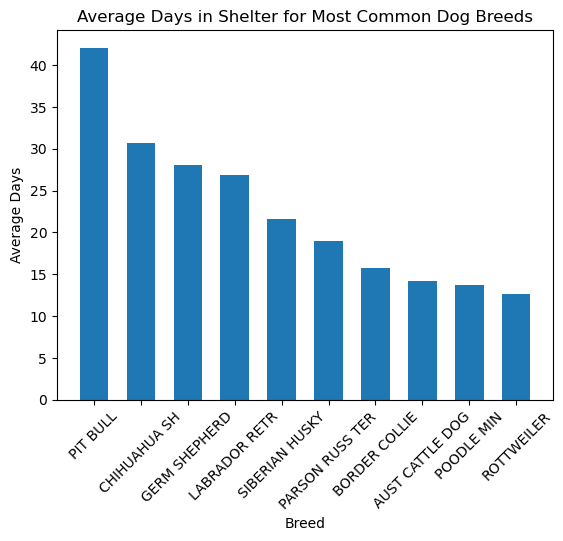

In [39]:
# Plot 1.1: Most Common Dog breeds by average days in shelter
sorted_dog_avg_days = dog_avg_days.sort_values(ascending=False)

plt.bar(dog_avg_days.index, sorted_dog_avg_days.values, width=0.6)
plt.title('Average Days in Shelter for Most Common Dog Breeds')
plt.xlabel('Breed')
plt.xticks(rotation=45) 
plt.ylabel('Average Days')
plt.show()

In the graph above, we observe that certain breeds such as Poodles, Australian Cattle Dogs, and Rottweilers tend to have shorter shelter stays. This is expected given their popularity and the higher likelihood of them being runaways, as it is rare to find these breeds as strays. For mixed-breed dogs, we designate the primary breed as the first one listed (i.e., the dominant breed). Notably, Pitbulls exhibit significantly longer shelter stays compared to other breeds. As we will explore further, this trend may be due to several factors, including the high likelihood that many Pitbulls are mixed breeds and the challenges associated with owning them.

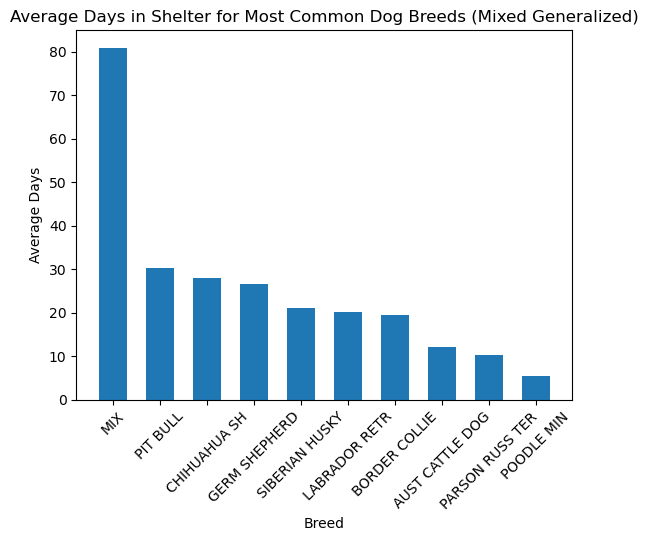

In [40]:
# Plot 1.2: Most Common Dog breeds by average days in shelter, generalizing mixed breeds
sorted_dog_avg_days_mix = dog_avg_days_mix.sort_values(ascending=False)

plt.bar(dog_avg_days_mix.index, sorted_dog_avg_days_mix.values, width=0.6)
plt.title('Average Days in Shelter for Most Common Dog Breeds (Mixed Generalized)')
plt.xlabel('Breed')
plt.xticks(rotation=45) 
plt.ylabel('Average Days')
plt.show()

On the graph above, we made a wide generalization for mixed breeds. We revised our filtering system so that any animal labeled as mixed or with more than one breed is classified as 'MIX'. With this update, the data presents a more accurate picture. Notably, while Pitbulls now show a shorter stay than before, they still remain in the shelter longer than most purebreds—likely reflecting the challenges associated with owning a breed that often faces public stigma. Mixed breed dogs, however, continue to stay much longer. This trend likely stems from persistent biases since many potential adopters still view mixed breeds as having unpredictable temperaments or uncertain health histories, even though mixed breeds can benefit from greater genetic diversity and fewer inherited issues.

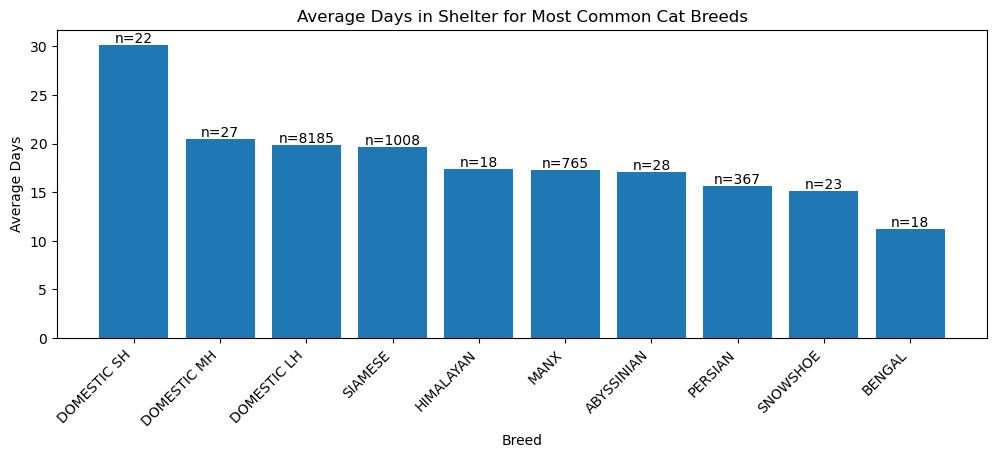

In [41]:
# Plot 2: Most Common Cat breeds by average days in shelter
sorted_cat_avg_days = cat_avg_days.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
plt.bar(cat_avg_days.index, sorted_cat_avg_days.values)
plt.title('Average Days in Shelter for Most Common Cat Breeds')
plt.xlabel('Breed')
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Average Days')

# adding count labels -  I think it is important to show this in the cat scenario since there's some low \'n\' values
for i, breed in enumerate(sorted_cat_avg_days.index):
    plt.text(i, sorted_cat_avg_days[breed] + 0.25, f"n={cat_breed_counts[breed]}", ha='center')

plt.show()

## Effects of Age and Days in Shelter

### Binned Analysis of Age and Days in Shelter
In order to further explore the relationship between an animal's age and its time spent in the shelter, we can analyze the data using age buckets and corresponding ranges of shelter days. The following plot shows a 2D histogram that bins the animals by age and shelter day providing a clearer picture of how specific age groups relate to the length of shelter stays.

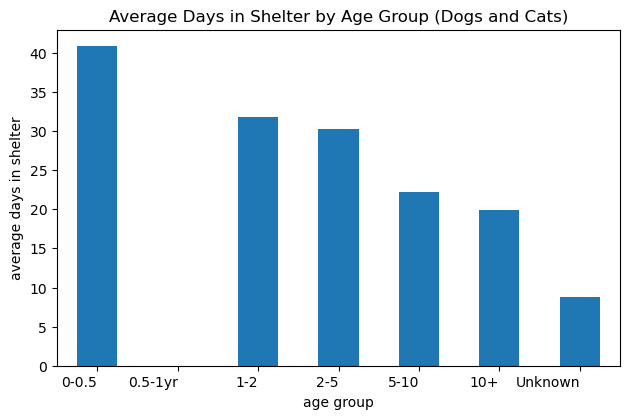

In [46]:
age_days_avg.plot(kind='bar')
plt.title("Average Days in Shelter by Age Group (Dogs and Cats)")
plt.xlabel("age group")
plt.ylabel("average days in shelter")
plt.tight_layout()
plt.xticks(rotation=0, ha='right') 
plt.show()

Data above looks good(at least we can see the relative primary colors), but doesn't give us the full picture, maybe there's just more black dogs. Let's explore some more. Out of all dogs of a given shade, what's the proportion successfully returned to their owner?

## Size

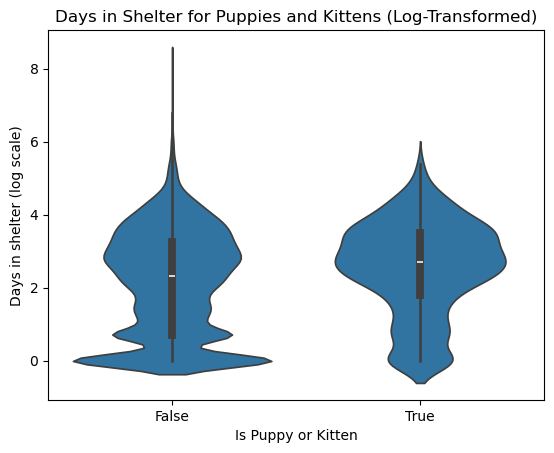

In [23]:
# create a new column to tell if an animal is a puppy or kitten
df["is_puppy_kitten"] = (df["Size"] == "KITTEN") | (df["Size"] == "PUPPY")
# create new column for log and use log1p to handle zeros
df["Days in Shelter_log"] = np.log1p(df["Days in Shelter"]) 
sns.violinplot(x="is_puppy_kitten", y="Days in Shelter_log", data=df)
plt.title("Days in Shelter for Puppies and Kittens (Log-Transformed)")
plt.xlabel("Is Puppy or Kitten")
plt.ylabel("Days in shelter (log scale)")
plt.show();

These two distributions look pretty simialar execept there is a spike close to 0 for non puppies and kittens. I think this is from peoples animals getting picked up off the street and returned to the owner.

## Outcome

I want to know how outcome type changes the duration an animal would stay. What outcome type has the longest stay on average?

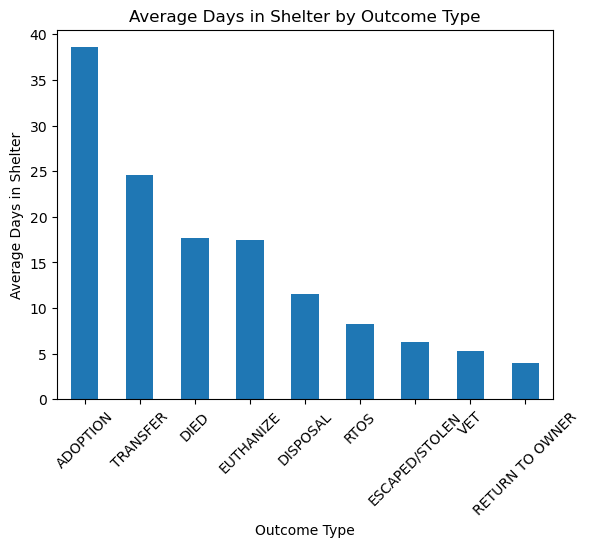

In [24]:
df.groupby("Outcome Type")["Days in Shelter"].mean().sort_values(ascending=False).plot.bar()
plt.xlabel("Outcome Type")
plt.ylabel("Average Days in Shelter")
plt.title("Average Days in Shelter by Outcome Type")
plt.xticks(rotation=45)
plt.show()

As we can see adopted animals stay the longest with an average of 40 days. This suggests that adoption is a proccess and takes time. I would also assume that the shelter staff are trying to find the best match possible for each dog so some people might get turned away.
Another interesting thing to note is how quickly animals get returned to their owner on average its about 4 days.

## Conclusions

For now we still need to explore more and improve the notebook. As it stands it's pretty messy but we just wanted to explore as much as we could first and see if we found anything of interest or significance rather than caring too much about form. As we hone down on our areas of interest we will make the data look better and have better descriptions and organization. Lastly exploring the effects of color might be more interesting(given our exploration) so we might pivot to focus more on that.

Days in shelter as it relates to animal type.

/var/folders/jr/xmjf4jsn7qs69fq20lfl_p_c0000gn/T/ipykernel_17175/3299137420.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10**3)


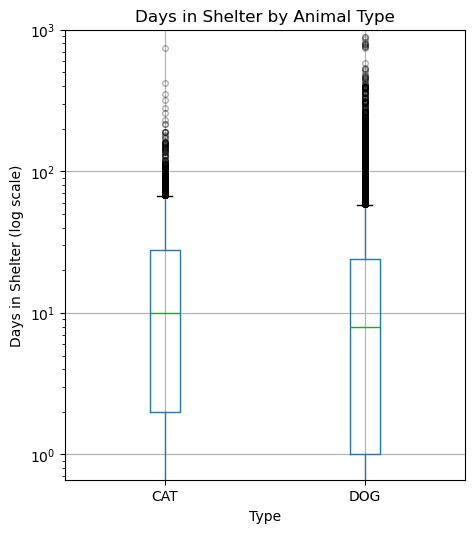

In [25]:
df_filtered = df[df['Type'].str.lower() != 'other']
flierprops = dict(marker='o', markersize=4,alpha=0.3, markerfacecolor ='none')
df_filtered.boxplot(column='Days in Shelter', by='Type', figsize=(5,6), flierprops=flierprops)
plt.yscale('log')  # Use log scale for skewed data
plt.ylim(0, 10**3)
plt.ylabel('Days in Shelter (log scale)')
plt.title('Days in Shelter by Animal Type')
plt.suptitle('')
plt.show();

## Days in shelter as it relates to sex and animal type.

/var/folders/jr/xmjf4jsn7qs69fq20lfl_p_c0000gn/T/ipykernel_17175/2096495062.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[0].set_ylim(0, 10**3)
/var/folders/jr/xmjf4jsn7qs69fq20lfl_p_c0000gn/T/ipykernel_17175/2096495062.py:39: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[1].set_ylim(0, 10**3)


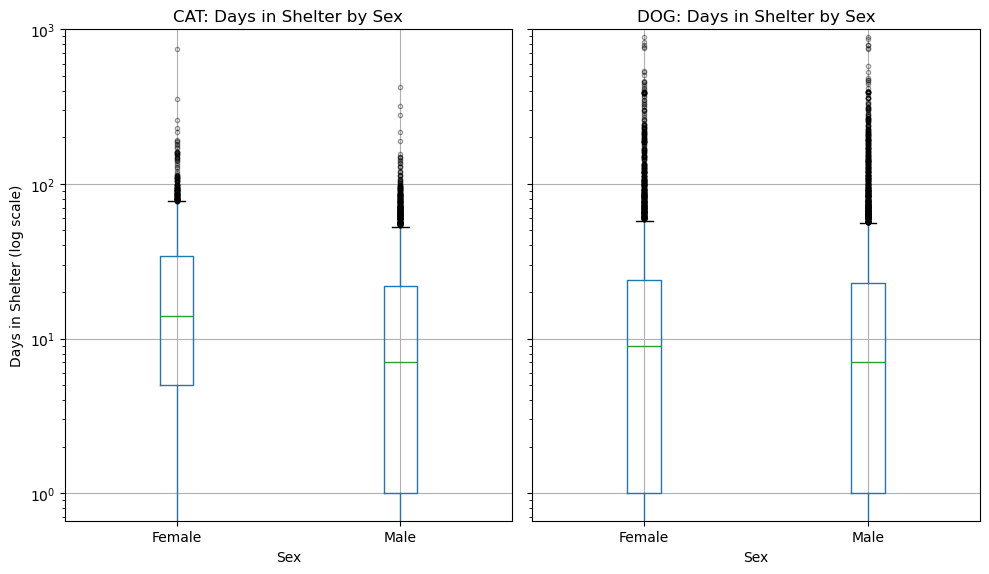

In [26]:
df = df[df['Type'].str.lower().isin(['cat', 'dog'])]

df['sex_binary'] = df['Sex'].apply(
    lambda s: 0 if ('female' in s.lower() or 'spay' in s.lower()) else 1
)
flierprops = dict(
    marker='o',
    markersize=3,
    markerfacecolor='none',
    alpha=0.4,
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)

df_cat = df[df['Type'].str.lower() == 'cat']
df_cat.boxplot(
    column='Days in Shelter',
    by='sex_binary',
    ax=axes[0],
    flierprops=flierprops
)

axes[0].set_yscale('log')
axes[0].set_ylim(0, 10**3)
axes[0].set_title('CAT: Days in Shelter by Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Days in Shelter (log scale)')
axes[0].set_xticklabels(['Female', 'Male'])

df_dog = df[df['Type'].str.lower() == 'dog']
df_dog.boxplot(
    column='Days in Shelter',
    by='sex_binary',
    ax=axes[1],
    flierprops=flierprops
)

axes[1].set_yscale('log')
axes[1].set_ylim(0, 10**3)
axes[1].set_title('DOG: Days in Shelter by Sex')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Female', 'Male'])
plt.suptitle('')
plt.tight_layout()
plt.show()